# Coronavirus Data Exploration
Getting and displaying data from the Johns Hopkins University Center for Systems Science and Engineering (github repo is at https://github.com/CSSEGISandData/COVID-19). There are so many cool visualization tools out there I thought I would throw something together. At the very least, this could be helpful. At best, it would be nice if people took these data frames and did something cool with them. 

## Get the data 
Download and put it into a data frame. I am extracting data for the United States, and focusing on confirmed cases thus far (rather than deaths or recovery), but all that data is in the data set and it is easy to extract. 

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from state_codes import us_state_abbrev #dictionary from names to state codes

In [2]:
# Full data frame
data_url = r'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
covid_df = pd.read_csv(data_url)
covid_df = covid_df.rename(columns = {'Province/State':'state', 'Country/Region': 'country', 'Lat': 'lat', 'Long': 'long'})

In [7]:
# Restriction to US data. Oh well.
covid_us = covid_df[covid_df['country'] == 'US']

In [95]:
covid_us.head()

,state,country,lat,long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20
98,Washington,US,47.4009,-121.4905,0,0,0,0,0,0,...,366,442,568,572,643,904,1076,1014,1376,1524
99,New York,US,42.1657,-74.9481,0,0,0,0,0,0,...,220,328,421,525,732,967,1706,2495,5365,8310
100,California,US,36.1162,-119.6816,0,0,0,0,0,0,...,177,221,282,340,426,557,698,751,952,1177
101,Massachusetts,US,42.2302,-71.5301,0,0,0,0,0,0,...,95,108,123,138,164,197,218,218,328,413
102,Diamond Princess,US,35.4437,139.6380,0,0,0,0,0,0,...,46,46,46,46,46,47,47,47,47,49


In [97]:
## Get state, latitutde, longitude, and total num cases (last column)
covid_us_totals = covid_us.iloc[:, [0, 2, 3, -1]]
covid_us_totals = covid_us_totals.rename(columns = {covid_us_totals.columns[-1]: 'cases'})
covid_us_totals.head(10)

,state,lat,long,cases
98,Washington,47.4009,-121.4905,1524
99,New York,42.1657,-74.9481,8310
100,California,36.1162,-119.6816,1177
101,Massachusetts,42.2302,-71.5301,413
102,Diamond Princess,35.4437,139.6380,49
103,Grand Princess,37.6489,-122.6655,23
104,Georgia,33.0406,-83.6431,420
105,Colorado,39.0598,-105.3111,363
106,Florida,27.7663,-81.6868,563
107,New Jersey,40.2989,-74.5210,890


Sorting is always fun if you want to be terrified. Would be fun to add a 'size' column and calculate the density of cases in each state.

In [104]:
sorted_by_cases = covid_us_totals.sort_values(by = ['cases'], ascending = False)
sorted_by_cases.head(10)

,state,lat,long,cases,state_code,label
99,New York,42.1657,-74.9481,8310,NY,New York<br>8310
98,Washington,47.4009,-121.4905,1524,WA,Washington<br>1524
100,California,36.1162,-119.6816,1177,CA,California<br>1177
107,New Jersey,40.2989,-74.5210,890,NJ,New Jersey<br>890
110,Illinois,40.3495,-88.9861,585,IL,Illinois<br>585
106,Florida,27.7663,-81.6868,563,FL,Florida<br>563
146,Michigan,43.3266,-84.5361,552,MI,Michigan<br>552
138,Louisiana,31.1695,-91.8678,538,LA,Louisiana<br>538
104,Georgia,33.0406,-83.6431,420,GA,Georgia<br>420
101,Massachusetts,42.2302,-71.5301,413,MA,Massachusetts<br>413


I mean, this wouldn't be an analysis if we didn't plot the exponential rise of cases, would it?

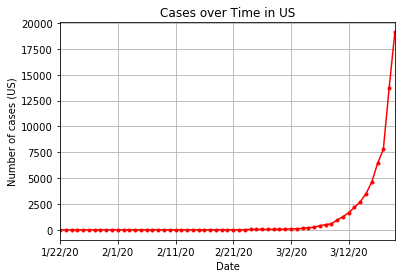

In [105]:
covid_time = covid_us[covid_us.columns[4:]].sum()
covid_time.plot(style = '.', color = 'red',  grid = True);
covid_time.plot(color = 'red', grid = True)
plt.xlabel('Date')
plt.ylabel('Number of cases (US)')
plt.title('Cases over Time in US');

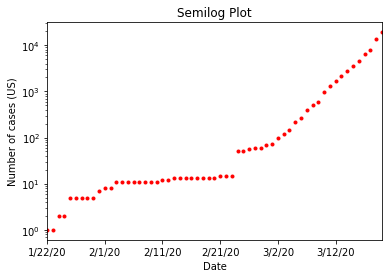

In [106]:
# same plot, semilog
covid_time.plot(style = '.', logy = True, color = 'red');
plt.xlabel('Date')
plt.ylabel('Number of cases (US)')
plt.title('Semilog Plot');

## On to maps
I'll be using Plotly (https://plot.ly/) to project the data to the US map.

In [101]:
# Add appropriate state codes
state_filter = covid_us_totals["state"].isin(us_state_abbrev.keys())
covid_us_totals = covid_us_totals[state_filter]
covid_us_totals['state_code'] = covid_us_totals['state'].map(us_state_abbrev)
covid_us_totals.head()

,state,lat,long,cases,state_code
98,Washington,47.4009,-121.4905,1524,WA
99,New York,42.1657,-74.9481,8310,NY
100,California,36.1162,-119.6816,1177,CA
101,Massachusetts,42.2302,-71.5301,413,MA
104,Georgia,33.0406,-83.6431,420,GA


In [102]:
# Plot choropleth map (must use log otherwise it looks awful--too many orders of mag)
fig = go.Figure(data=go.Choropleth(
    locations=covid_us_totals['state_code'], # Spatial coordinates
    z = np.log10(covid_us_totals['cases'].astype(float)), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar=dict(title='#Cases (Log)', tickprefix='1.e')))

fig.update_layout(
    title_text = 'Covid Cases by State: Choropleth Map',
    geo_scope='usa', # limit map scope to USA
)

fig.show()

Next, on to the bubble map which in some wasy is easier to interpret, in other ways harder. Both together are probably best. Note first need to make labels and add as column to the dataframe for it to show in an elegant way.

In [103]:
#Add column for labels
covid_w_labels = covid_us_totals
covid_w_labels['label'] = covid_us_totals['state'] + '<br>' + covid_us_totals['cases'].astype(str)
covid_w_labels.head(5)

# Set size bounds
size_vals = covid_us_totals['cases']
max_marker_size = 75
min_marker_size = 3
sizeref_scale = 2. * max(size_vals) / (max_marker_size ** 2)

# Plot, plotly, plot!
fig = go.Figure(data=go.Scattergeo(
        lon = covid_w_labels['long'],
        lat = covid_us_totals['lat'],
        mode='markers',
        text = covid_w_labels['label'],
        marker=dict(
            size=size_vals,
            sizemode='area',
            sizeref=sizeref_scale,
            sizemin=min_marker_size,
            color = 'Red',
        )))
     
fig.update_layout(title_text = 'Covid Cases by State: Bubble Map',
    geo_scope='usa', # limit map scope to USA
)
